# Beating Food101 paper

In this notebook I'm trying to beat [DeepFood paper](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment) and of course the original [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/). It has 101 food categories, with 101'000 images. <br> <br>
DeepFood is a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.

## Here is a plan of this work
* Using TensorFlow Datasets to download and explore data
* Creating preprocessing function for our data
* Batching & preparing datasets for modelling (**making our datasets run fast**)
* Creating modelling callbacks
* Setting up **mixed precision training**
* Building a feature extraction model 
* Fine-tuning the feature extraction model 
* Viewing training results on TensorBoard

First of all, we're going to use a mixed presicion paradigm. It means that if our GPU compute capability coefficient is greater then 7 - we can apply mixed presicion to our training process. <br> 
We're working in a Colab. It allows us to use powerful GPUs! <br> <br>
Let's check our GPU

In [ ]:
!nvidia-smi

Mon Aug  8 12:34:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Tesle T4 is a powerful chip with a 7.5 compute capability.

**Note.** Since mixed precision training was introduced in TensorFlow 2.4.0, we have to make sure that we've got at least TensorFlow 2.4.0+.

In [2]:
1# Check TensorFlow version (should be 2.4.0+)
import tensorflow as tf
print(tf.__version__)

2.8.2


In [3]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [4]:
# Load in the data
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteZE52Q3/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteZE52Q3/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [5]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [6]:
# Get some class names
from numpy.random import choice
class_names = ds_info.features["label"].names
choice(class_names, 10)

array(['peking_duck', 'breakfast_burrito', 'nachos', 'fish_and_chips',
       'takoyaki', 'pad_thai', 'paella', 'cheesecake', 'fried_rice',
       'french_onion_soup'], dtype='<U23')

In [7]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

# What does one sample of our training data look like?
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Let's loop through our single training sample and get some info from the `image_tensor` and `label`.


In [8]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 65
  Class name (str form): mussels
        


## Plot an image

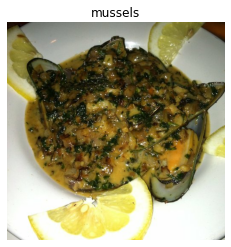

In [9]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

## Preprocessing data

In [10]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [11]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[19  6  0]
  [29 16  8]
  [34 21 13]
  ...
  [36 19  3]
  [35 19  3]
  [36 20  4]]

 [[20  7  0]
  [28 15  7]
  [34 21 13]
  ...
  [37 20  4]
  [37 20  4]
  [37 21  5]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[25.244898   12.244898    4.7295923 ]
  [32.40816    19.408163   11.408163  ]
  [32.719387   19.719387   10.719387  ]
  ...
  [39.005093   20.994862    3.4999783 ]
  [36.31123    19.31123     2.1173685 ]
  [36.413277   20.000034    4.000035  ]]

 [[19.897957    6.8979583   0.18367279]
  [28.943878   15.943878    7.9438777 ]
  [22.112242    9.112244    1.1122435 ]
  ...
  [48.89794    27.015284    6.1428356 ]
  [44.642845   23.852028    3.0714417 ]
  [42.760204   21.954084    3.0714283 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


In [12]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [13]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create callbacks

In [14]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [15]:
# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_acc", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved 

## Setup mixed precision training

In [16]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision 

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [17]:
mixed_precision.global_policy() # should output "mixed_float16"

<Policy "mixed_float16">

In [18]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
# Check out our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False flo

# Fit the feature extraction model

In [ ]:
history_1 = model.fit(train_data,
                      epochs = 3,
                      validation_data = test_data,
                      validation_steps = int(0.15 * len(test_data)),
                      callbacks = [create_tensorboard_callback('Food101_model', 'step_1_3_epochs'),
                                   model_checkpoint])

Saving TensorBoard log files to: Food101_model/step_1_3_epochs/20220808-150429
Epoch 1/3
2368/2368 [==============================] - 183s 77ms/step - loss: 1.0460 - accuracy: 0.7257 - val_loss: 1.0516 - val_accuracy: 0.7177
Epoch 2/3
2368/2368 [==============================] - 184s 77ms/step - loss: 0.9732 - accuracy: 0.7446 - val_loss: 1.0595 - val_accuracy: 0.7166
Epoch 3/3
2368/2368 [==============================] - 191s 80ms/step - loss: 0.9153 - accuracy: 0.7601 - val_loss: 1.0539 - val_accuracy: 0.7097


In [ ]:
model.evaluate(test_data)

790/790 [==============================] - 51s 64ms/step - loss: 1.0642 - accuracy: 0.7122


[1.0641902685165405, 0.7121584415435791]

In [22]:
from google.colab import drive
drive.mount('/gdrive')


Mounted at /gdrive


In [ ]:
model.save('Food101_model_step1.h5')

import shutil
shutil.copy('Food101_model_step1.h5','../gdrive/MyDrive/Colab Notebooks/Food101')

'../gdrive/MyDrive/Colab Notebooks/Food101/Food101_model_step1.h5'

## Fine tuning

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [25]:
base_model.trainable = True

In [26]:
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "mixed_float16">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed

In [20]:
ES_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)


In [21]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(lr = 0.0001),
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [27]:
history_2 = model.fit(train_data,
                      epochs = 10,
                      validation_data = test_data,
                      validation_steps = int(0.15 * len(test_data)),
                      callbacks = [create_tensorboard_callback('Food101_model', 'Fine_tuning'),
                                   model_checkpoint,
                                   ES_callback])

Saving TensorBoard log files to: Food101_model/Fine_tuning/20220809-112035
Epoch 1/10
2368/2368 [==============================] - 342s 144ms/step - loss: 1.4794 - accuracy: 0.6172 - val_loss: 0.9056 - val_accuracy: 0.7511
Epoch 2/10
2368/2368 [==============================] - 337s 142ms/step - loss: 0.8566 - accuracy: 0.7682 - val_loss: 0.7853 - val_accuracy: 0.7797
Epoch 3/10
2368/2368 [==============================] - 339s 142ms/step - loss: 0.5503 - accuracy: 0.8448 - val_loss: 0.7415 - val_accuracy: 0.7950
Epoch 4/10
2368/2368 [==============================] - 334s 141ms/step - loss: 0.3201 - accuracy: 0.9073 - val_loss: 0.8508 - val_accuracy: 0.7858
Epoch 5/10
2368/2368 [==============================] - 339s 142ms/step - loss: 0.1882 - accuracy: 0.9427 - val_loss: 0.9582 - val_accuracy: 0.7765
Epoch 6/10
2368/2368 [==============================] - 345s 145ms/step - loss: 0.1328 - accuracy: 0.9574 - val_loss: 0.9538 - val_accuracy: 0.7969
Epoch 7/10
2368/2368 [===============

In [28]:
model.evaluate(test_data)

790/790 [==============================] - 50s 63ms/step - loss: 1.1309 - accuracy: 0.7829


[1.1308813095092773, 0.7828514575958252]

## Result
We beat a DF paper with 78,3% of accuracy using Fine-tuning

In [29]:
model.save('Food101_model_step1.h5')

import shutil
shutil.copy('Food101_model_step1.h5','../gdrive/MyDrive/Colab Notebooks/Food101')

'../gdrive/MyDrive/Colab Notebooks/Food101'